<a href="https://colab.research.google.com/github/davidArtme/pysystem-coupling/blob/main/PINN_heat_reactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(0)
np.random.seed(0)


cpu


In [ ]:
# ---------- MATERIAL PROPERTIES ----------

props = {
    "air":   dict(rho=1.225,  cp=1006.0, k=0.0242),
    "steel": dict(rho=8000.0, cp=700.0,  k=25.0),
    "ch4":   dict(rho=0.6679, cp=2000.0, k=0.0332),
}

T0 = 300.0        # initial temperature [K]
q_flux = 5000.0   # W/m2


In [ ]:
#----------------LOAD NODES PLACEMENT----------------

def load_nodes(path):
    df = pd.read_csv(path)
    return torch.tensor(df[['    x-coordinate', '    y-coordinate']].values, device=device)

nodes_air = load_nodes("/content/nodes-fluid-air")
nodes_ch4 = load_nodes("/content/nodes-fluid-ch4")
nodes_steel = load_nodes("/content/nodes-solid-steel")

In [ ]:
#----------------NORMALIZATION----------------

Lx = 0.16     # domain size [m]
Tmax = 50.0

def normalize_xy(xy):
    return xy / Lx

def normalize_t(t):
    return t / Tmax


In [ ]:
#----------------NN DEFINITION----------------

class MLP(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        return self.layers[-1](x)


In [ ]:
layers = [3, 128, 128, 128, 128, 1]

net_air   = MLP(layers).to(device)
net_steel = MLP(layers).to(device)
net_ch4   = MLP(layers).to(device)


In [ ]:
#----------------AUTOGRAD----------------

def grad(outputs, inputs):
    return torch.autograd.grad(
        outputs, inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True
    )[0]

def laplacian(T, x):
    grad_T = grad(T, x)
    lap = 0.0
    for i in range(grad_T.shape[1]):
        lap += grad(grad_T[:, i:i+1], x)[:, i:i+1]
    return lap


In [ ]:
#----------------PDE RESIDUAL----------------

def pde_residual(net, xy, t, mat):
    xy.requires_grad_(True)
    t.requires_grad_(True)

    X = torch.cat([xy, t], dim=1)
    T = T0 + net(X)

    T_t = grad(T, t)
    lap_T = laplacian(T, xy)

    rho = props[mat]["rho"]
    cp  = props[mat]["cp"]
    k   = props[mat]["k"]

    return rho * cp * T_t - k * lap_T # governing equation


In [ ]:
#----------------INITIAL CONDITION LOSS----------------

def ic_loss(net, xy):
    t0 = torch.zeros((xy.shape[0],1), device=device)
    T = T0 + net(torch.cat([xy, t0], dim=1))
    return torch.mean((T - T0)**2)


In [ ]:
#----------------NEUMANN BOUNDARY CONDITION LOSS----------------

def neumann_loss(net, xy, t, normal, q_target, mat):
    xy.requires_grad_(True)
    t.requires_grad_(True)

    T = T0 + net(torch.cat([xy, t], dim=1))
    grad_T = grad(T, xy)

    flux = -props[mat]["k"] * torch.sum(grad_T * normal, dim=1, keepdim=True)
    return torch.mean((flux - q_target)**2)


In [ ]:
#----------------INTERFACE LOSS----------------

def interface_loss(net_s, net_f, xy, t, normal, mat_f):
    xy.requires_grad_(True)
    t.requires_grad_(True)

    Ts = T0 + net_s(torch.cat([xy, t], dim=1))
    Tf = T0 + net_f(torch.cat([xy, t], dim=1))

    # Temperature continuity
    loss_T = torch.mean((Ts - Tf)**2)

    # Flux continuity
    grad_Ts = grad(Ts, xy)
    grad_Tf = grad(Tf, xy)

    flux_s = props["steel"]["k"] * torch.sum(grad_Ts * normal, dim=1, keepdim=True)
    flux_f = props[mat_f]["k"] * torch.sum(grad_Tf * normal, dim=1, keepdim=True)

    loss_flux = torch.mean((flux_s - flux_f)**2)

    return loss_T + loss_flux


In [ ]:
#----------------TRAINING----------------

optimizer = torch.optim.Adam(
    list(net_air.parameters()) +
    list(net_steel.parameters()) +
    list(net_ch4.parameters()),
    lr=1e-2
)


In [ ]:
def sample_xy(nodes_xy, N):
    idx = torch.randint(0, nodes_xy.shape[0], (N,), device=device)
    return nodes_xy[idx]

def train_step():
    optimizer.zero_grad()

    N = 500  # collocation batch size per material (tied to your time batch)
    t = torch.rand((N, 1), device=device)  # normalized time in (0,1)

    # sample spatial points for each material (then normalize)
    xy_air   = normalize_xy(sample_xy(nodes_air, N))
    xy_ch4   = normalize_xy(sample_xy(nodes_ch4, N))
    xy_steel = normalize_xy(sample_xy(nodes_steel, N))

    # PDE residuals
    res_air   = pde_residual(net_air,   xy_air,   t, "air")
    res_ch4   = pde_residual(net_ch4,   xy_ch4,   t, "ch4")
    res_steel = pde_residual(net_steel, xy_steel, t, "steel")

    loss_pde = (res_air.pow(2).mean() + res_ch4.pow(2).mean() + res_steel.pow(2).mean())

    # IC: you can also batch this instead of using all nodes
    xy_air_ic   = normalize_xy(sample_xy(nodes_air, N))
    xy_ch4_ic   = normalize_xy(sample_xy(nodes_ch4, N))
    xy_steel_ic = normalize_xy(sample_xy(nodes_steel, N))

    loss_ic = (ic_loss(net_air, xy_air_ic) + ic_loss(net_ch4, xy_ch4_ic) + ic_loss(net_steel, xy_steel_ic))

    loss = loss_pde + 10.0 * loss_ic
    loss.backward()
    optimizer.step()
    return loss.item()


In [ ]:
iter_number = 40000

for it in range(1, iter_number):
    loss = train_step()
    if it % 500 == 0:
        print(f"Iter {it:6d} | Loss = {loss:.4e}")


Iter    500 | Loss = 5.1204e+03
Iter   1000 | Loss = 1.8470e+03
Iter   1500 | Loss = 9.8124e+02
Iter   2000 | Loss = 4.1496e+02
Iter   2500 | Loss = 1.4226e+02
Iter   3000 | Loss = 6.4060e+01
Iter   3500 | Loss = 4.5779e+01
Iter   4000 | Loss = 4.0735e+01
Iter   4500 | Loss = 4.8838e+01
Iter   5000 | Loss = 4.3502e+01
Iter   5500 | Loss = 3.1609e+01
Iter   6000 | Loss = 2.9311e+01
Iter   6500 | Loss = 2.5722e+01
Iter   7000 | Loss = 2.8284e+01
Iter   7500 | Loss = 1.5362e+01
Iter   8000 | Loss = 1.5574e+01
Iter   8500 | Loss = 1.3245e+01
Iter   9000 | Loss = 5.9608e+00
Iter   9500 | Loss = 4.6843e+00
Iter  10000 | Loss = 6.6484e+00
Iter  10500 | Loss = 5.5950e+00
Iter  11000 | Loss = 2.0641e+00
Iter  11500 | Loss = 5.5177e+01
Iter  12000 | Loss = 1.5658e+00
Iter  12500 | Loss = 7.5567e-01
Iter  13000 | Loss = 1.0162e+00
Iter  13500 | Loss = 3.8281e-01
Iter  14000 | Loss = 8.4711e+00
Iter  14500 | Loss = 9.0535e-01
Iter  15000 | Loss = 8.4773e-01
Iter  15500 | Loss = 1.3685e-01
Iter  16

In [1]:
def eval_temperature(net, nodes):
    t = torch.ones((nodes.shape[0],1), device=device)
    xy = normalize_xy(nodes)
    return (T0 + net(torch.cat([xy, t], dim=1))).detach().cpu().numpy()


In [2]:
def avg_ch4_temperature(times):
    temps = []
    xy = normalize_xy(nodes_ch4)
    for tval in times:
        t = torch.full((xy.shape[0],1), tval/Tmax, device=device)
        T = T0 + net_ch4(torch.cat([xy, t], dim=1))
        temps.append(T.mean().item())
    return temps


In [3]:
print([name for name in globals().keys() if "net" in name])


[]


In [4]:
T_air_1000   = eval_temperature(net_air, nodes_air).ravel()
T_steel_1000 = eval_temperature(net_steel, nodes_steel).ravel()
T_ch4_1000   = eval_temperature(net_ch4, nodes_ch4).ravel()


NameError: name 'net_air' is not defined

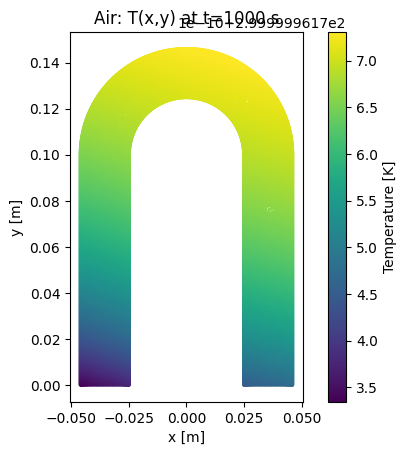

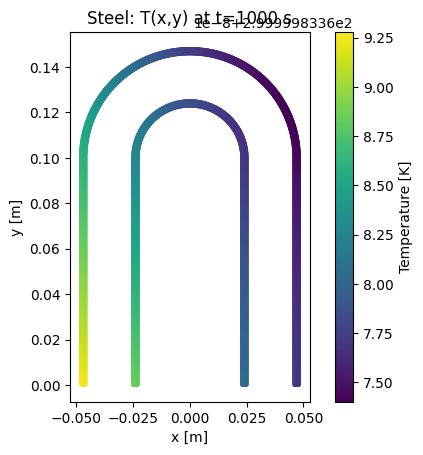

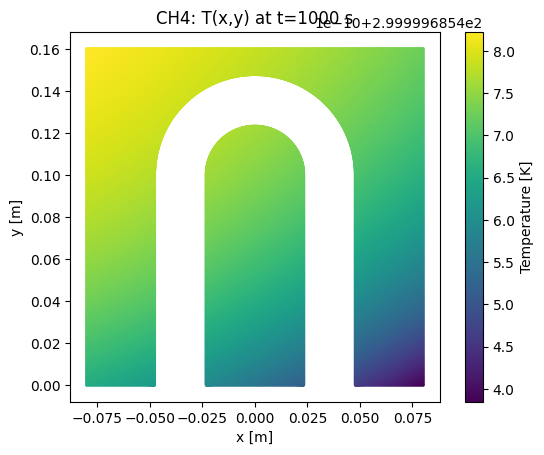

In [ ]:
import matplotlib.pyplot as plt

def plot_field(nodes, T, title):
    x = nodes[:,0].detach().cpu().numpy()
    y = nodes[:,1].detach().cpu().numpy()

    plt.figure()
    sc = plt.scatter(x, y, c=T, s=3)
    plt.colorbar(sc, label="Temperature [K]")
    plt.gca().set_aspect("equal", "box")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.title(title)
    plt.show()

plot_field(nodes_air,   T_air_1000,   "Air: T(x,y) at t=1000 s")
plot_field(nodes_steel, T_steel_1000, "Steel: T(x,y) at t=1000 s")
plot_field(nodes_ch4,   T_ch4_1000,   "CH4: T(x,y) at t=1000 s")


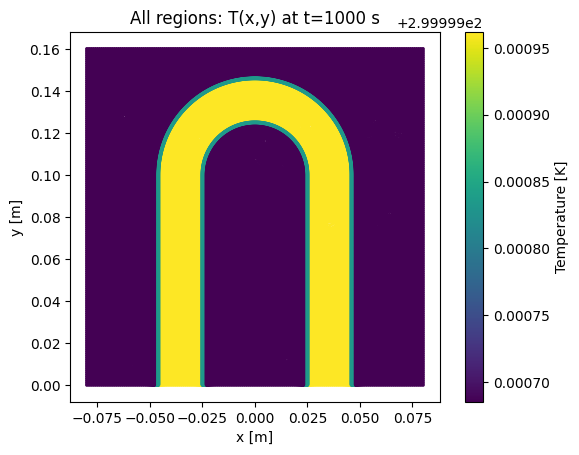

In [ ]:
nodes_all = torch.cat([nodes_air, nodes_steel, nodes_ch4], dim=0)
T_all = np.concatenate([T_air_1000, T_steel_1000, T_ch4_1000], axis=0)
plot_field(nodes_all, T_all, "All regions: T(x,y) at t=1000 s")


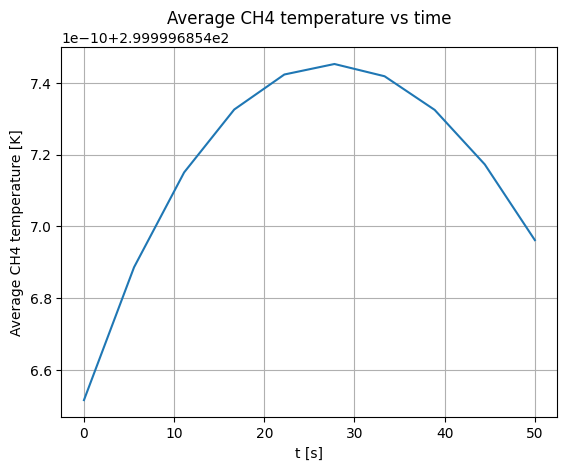

In [ ]:
times = np.linspace(0, 50, 10)  # 0..1000s, 101 points
avgT = avg_ch4_temperature(times)

plt.figure()
plt.plot(times, avgT)
plt.xlabel("t [s]")
plt.ylabel("Average CH4 temperature [K]")
plt.title("Average CH4 temperature vs time")
plt.grid(True)
plt.show()


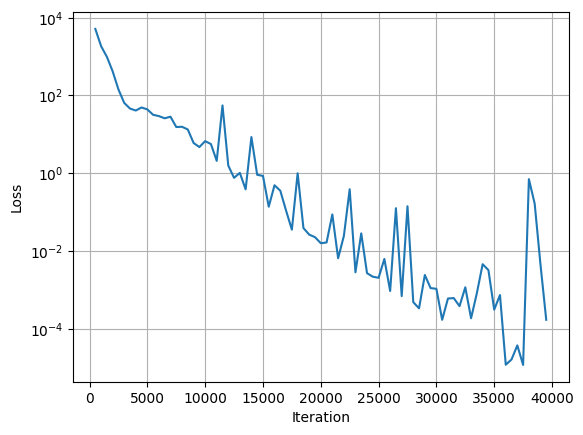

In [ ]:
import matplotlib.pyplot as plt

iters = [
    500,1000,1500,2000,2500,3000,3500,4000,4500,5000,
    5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,
    10500,11000,11500,12000,12500,13000,13500,14000,14500,15000,
    15500,16000,16500,17000,17500,18000,18500,19000,19500,20000,
    20500,21000,21500,22000,22500,23000,23500,24000,24500,25000,
    25500,26000,26500,27000,27500,28000,28500,29000,29500,30000,
    30500,31000,31500,32000,32500,33000,33500,34000,34500,35000,
    35500,36000,36500,37000,37500,38000,38500,39000,39500
]

loss = [
    5.1204e3,1.8470e3,9.8124e2,4.1496e2,1.4226e2,6.4060e1,4.5779e1,4.0735e1,
    4.8838e1,4.3502e1,3.1609e1,2.9311e1,2.5722e1,2.8284e1,1.5362e1,
    1.5574e1,1.3245e1,5.9608e0,4.6843e0,6.6484e0,5.5950e0,2.0641e0,
    5.5177e1,1.5658e0,7.5567e-1,1.0162e0,3.8281e-1,8.4711e0,9.0535e-1,
    8.4773e-1,1.3685e-1,4.8788e-1,3.5229e-1,1.0822e-1,3.5141e-2,
    9.9178e-1,3.8693e-2,2.6157e-2,2.2531e-2,1.5767e-2,1.6420e-2,
    8.6532e-2,6.4668e-3,2.4423e-2,3.8509e-1,2.8133e-3,2.8200e-2,
    2.6701e-3,2.1683e-3,2.0301e-3,6.1977e-3,9.3081e-4,1.2524e-1,
    6.8692e-4,1.4076e-1,4.7993e-4,3.3243e-4,2.3952e-3,1.1040e-3,
    1.0560e-3,1.6856e-4,5.9458e-4,6.1076e-4,3.7866e-4,1.1562e-3,
    1.8481e-4,8.1617e-4,4.5417e-3,3.2050e-3,3.0831e-4,7.3124e-4,
    1.1787e-5,1.6116e-5,3.7044e-5,1.1653e-5,6.9983e-1,1.6494e-1,
    4.5366e-3,1.6895e-4
]

plt.figure()
plt.semilogy(iters, loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
